In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set( font_scale=2,
         style="whitegrid",
         rc={'figure.figsize':(20,7)} )

In [3]:
ads_data = pd.read_csv('/home/jupyter-i.zhusupov-8/shared/homeworks/python_ds_miniprojects/6/ads_data.csv')

In [4]:
ads_clients_data = pd.read_csv('/home/jupyter-i.zhusupov-8/shared/homeworks/python_ds_miniprojects/6/ads_clients_data.csv')

Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Тонкий момент: помните, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. Округлите ответы до целых чисел.

In [5]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [6]:
ads_data_for_event = ( ads_data
     .groupby(['ad_id','event'], as_index = False)
     .agg({'time':'count'})        
)

In [11]:
ads_data_for_event_pivot = ads_data_for_event.pivot(index = 'ad_id', columns = 'event', values = 'time').fillna(0).reset_index()
ads_data_for_event_pivot.describe()

event,ad_id,click,view
count,965.000000,965.000000,965.000000
mean,57971.024870,113.137824,923.131606
std,38810.046681,3404.699975,12945.945595
min,2.000000,0.000000,0.000000
25%,29768.000000,0.000000,35.000000
50%,43179.000000,1.000000,82.000000
75%,107250.000000,3.000000,208.000000
max,122078.000000,105767.000000,351802.000000


Давайте посмотрим на распределение показов объявлений!

По оси x – число показов По оси y – доля объявлений с такими показами Прологарифмируйте число показов, а затем постройте такой график, чтобы можно было понять форму распределения.

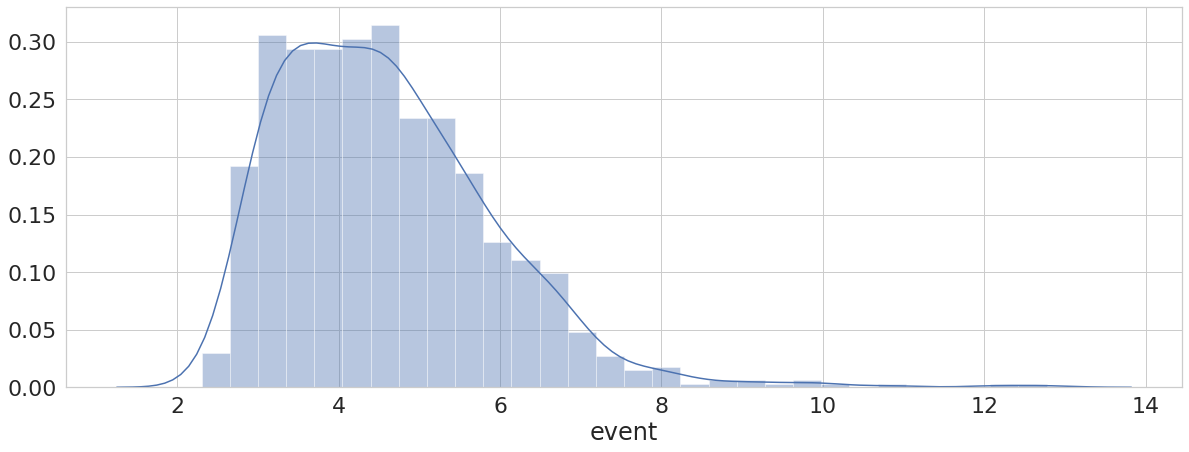

In [166]:
ads_data.query('event == "view"').groupby('ad_id', as_index = False).agg({'event':'count'})
np.log(ads_data.query('event == "view"').groupby('ad_id', as_index = False).agg({'event':'count'}).event)
sns.distplot(np.log(ads_data.query('event == "view"').groupby('ad_id', as_index = False).agg({'event':'count'}).event))


Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных. Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?

In [168]:
for_rolling_mean = ( ads_data
     .query('event == "view"')
     .groupby(['ad_id','date'], as_index = False)
     .agg({'time':'count'})
 )

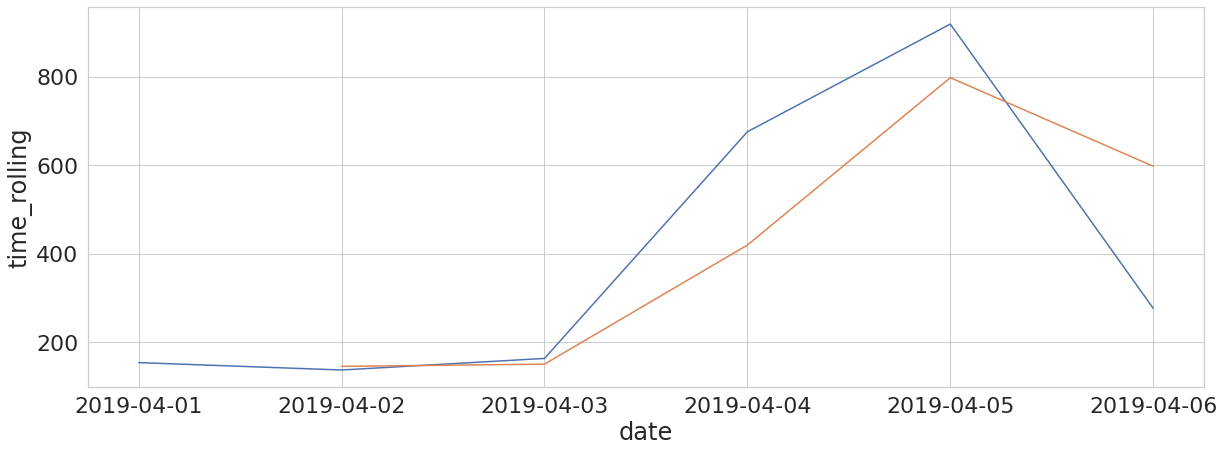

In [153]:
for_rolling_mean = for_rolling_mean.groupby('date',as_index = False).agg({'time':'mean'})
for_rolling_mean['time_rolling'] = for_rolling_mean.rolling(2).mean().round().dropna()
sns.lineplot(x = 'date', y = 'time', data = for_rolling_mean)
sns.lineplot(x = 'date', y = 'time_rolling', data = for_rolling_mean)

In [155]:
for_rolling_mean['difference_between_mean_and_rolling_mean'] = abs(for_rolling_mean.time - for_rolling_mean.time_rolling)

In [159]:
for_rolling_mean.sort_values('difference_between_mean_and_rolling_mean')

,date,time,time_rolling,difference_between_mean_and_rolling_mean
1,2019-04-02,137.786982,146.0,8.213018
2,2019-04-03,163.952778,151.0,12.952778
4,2019-04-05,919.109677,798.0,121.109677
3,2019-04-04,675.901720,420.0,255.901720
5,2019-04-06,277.122727,598.0,320.877273
0,2019-04-01,154.482270,NaN,NaN


Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).В качестве ответа укажите среднее число дней

In [12]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [13]:
ads_data_total = ads_data.merge(ads_clients_data, on = 'client_union_id' )

In [14]:
ads_data_total[['date_x', 'date_y', 'create_date']] = ads_data_total[['date_x', 'date_y', 'create_date']].apply(pd.to_datetime)

In [15]:
ads_data_total['difference_time'] = (ads_data_total.date_x - ads_data_total.create_date)

In [16]:
creation_days = ads_data_total.groupby('client_union_id', as_index=False).agg({'difference_time':'min'})

In [20]:
creation_days.difference_time.mean()

Timedelta('124 days 09:04:43.532219570')

Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

In [269]:
creation_days = creation_days.loc[creation_days.difference_time <= pd.Timedelta(365, unit='day')]

In [278]:
convertion_rate = round(creation_days.client_union_id.nunique() / ads_clients_data.client_union_id.nunique() * 100, 2)

In [280]:
convertion_rate

0.69

Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).

In [316]:
time_interval = [pd.to_timedelta('0 days'), pd.to_timedelta('30 days'),pd.to_timedelta('90 days'),pd.to_timedelta('180 days'),pd.to_timedelta('360 days')]

In [317]:
ads_data_total['interval_of_creation'] = pd.cut(ads_data_total.difference_time, time_interval )

In [319]:
(creation_days.difference_time <= pd.to_timedelta('30 days')).sum()

11

И последнее задание: постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них. 

In [320]:
for_grafik_intervals_of_creation = ads_data_total.groupby('interval_of_creation', as_index = False).agg({'client_union_id':'nunique'})

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

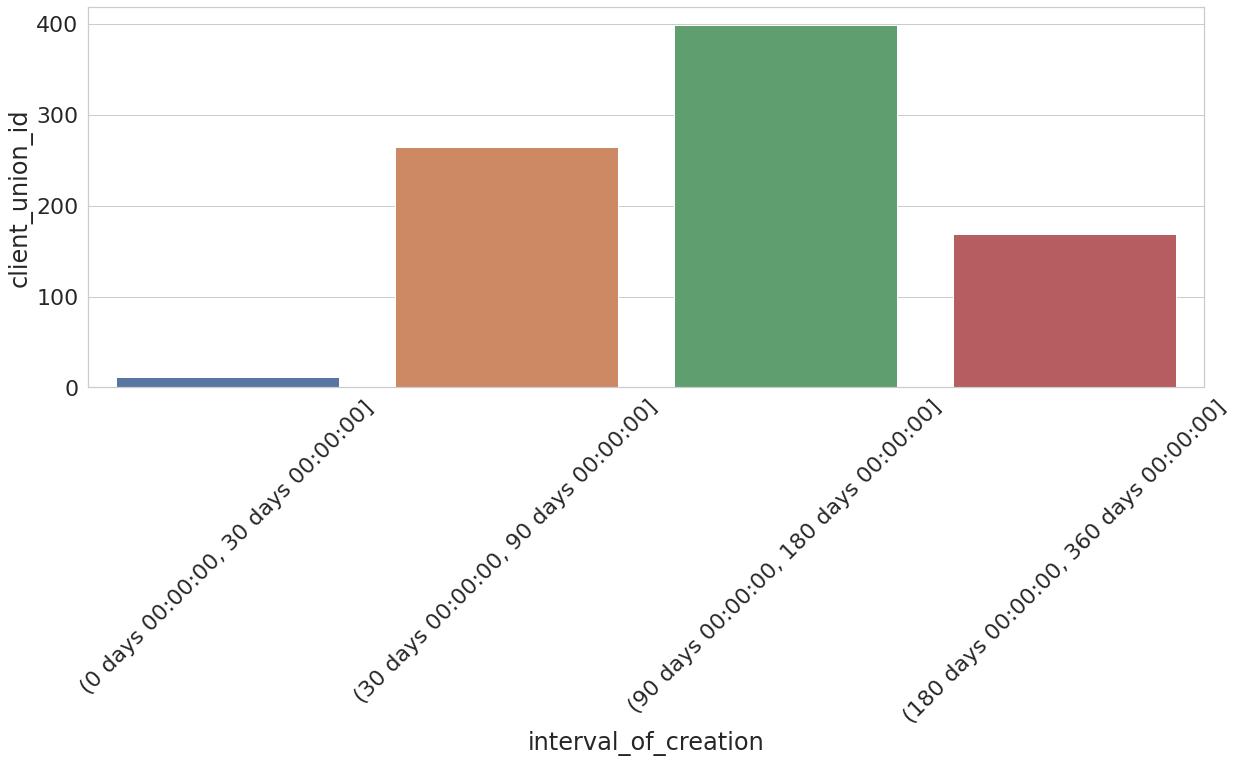

In [321]:
sns.barplot(x = 'interval_of_creation', y = 'client_union_id', data = for_grafik_intervals_of_creation)
plt.xticks(rotation=45)